In [2]:
from pybaseball import statcast
from pybaseball import pitching_stats_bref
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [3]:
bref2021 = pitching_stats_bref("2021")
bref2022 = pitching_stats_bref("2022")

bref2021 = bref2021.rename(columns={'ERA': 'ERA2021'})
bref2022 = bref2022.rename(columns={'ERA': 'ERA2022'})

bref2021 = bref2021[bref2021['IP'] >= 60]
bref2022 = bref2022[bref2022['IP'] >= 60]

In [4]:
savant2021 = statcast(start_dt= "2021-04-01", end_dt = "2021-11-15")

This is a large query, it may take a moment to complete


100%|██████████| 229/229 [00:17<00:00, 13.27it/s]


In [5]:
savant2021 = savant2021.rename(columns={'player_name': 'Name', 'pitch_type': 'Pitch Type'})

In [6]:
def flip_names(name):
    first_name, last_name = name.split(", ")
    return f"{last_name} {first_name}"

savant2021['Name'] = savant2021["Name"].apply(flip_names)

In [7]:
player_grouped2021 = savant2021.groupby(['Name']).agg(
    Pitches = ('Pitch Type', 'count'),
    BB = ('events', lambda x: (x == 'walk').sum()),
    HBP = ('events', lambda x: (x == 'hit_by_pitch').sum()),
    K = ('events', lambda x: (x == 'strikeout').sum()),
    TBF = ('events', lambda x: (x.isin(['other_out', 'single', 'double', 'triple', 'home_run', 'walk', 'strikeout', 'field_out', 'hit_by_pitch', 'sac_fly', 'sac_fly_double_play', 'sac_bunt', 'field_error', 'fielders_choice', 'double_play', 'fielders_choice_out', 'sac_fly_double_play', 'strikeout_double_play', 'catcher_interf', 'triple_play', 'grounded_into_double_play'])).sum()),
    GB = ('bb_type', lambda x: (x == 'ground_ball').sum()),
    BIP = ('bb_type', lambda x: (x.isin(['ground_ball', 'line_drive', 'fly_ball', 'popup'])).sum()),
    xwOBA = ('estimated_woba_using_speedangle', 'mean'),
    Run_Value = ('delta_run_exp', 'sum'),
    CS_Percent = ('description', lambda x: round((x == 'called_strike').mean() * 100, 2)),
    SwStr_Percent = ('description', lambda x: round((x.isin(['swinging_strike', 'swinging_strike_blocked'])).mean() * 100, 2)))

player_grouped2021 = player_grouped2021[player_grouped2021['TBF'] >= 230]
player_grouped2021

,Pitches,BB,HBP,K,TBF,GB,BIP,xwOBA,Run_Value,CS_Percent,SwStr_Percent
Name,,,,,,,,,,,
A.J. Minter,1058,22,2,75,263,78,168,0.317923,-7.188,16.45,14.93
Aaron Bummer,1012,27,4,82,251,109,142,0.282797,-3.676,19.29,12.93
Aaron Civale,1909,31,4,97,487,165,364,0.386011,-6.563,16.40,9.48
Aaron Nola,2971,38,9,223,739,199,478,0.371008,-1.291,18.38,12.76
Adam Cimber,1022,12,7,51,271,113,212,0.311738,-11.189,16.14,9.69
...,...,...,...,...,...,...,...,...,...,...,...
Zach Pop,936,22,8,51,239,95,163,0.326926,10.139,15.17,11.22
Zach Thompson,1194,27,3,66,311,98,218,0.325234,-7.058,15.41,11.64
Zack Greinke,2693,39,2,124,715,261,561,0.359226,-4.538,17.42,9.39


In [8]:
# Creation of my stat Simple Predicted Run Average
player_grouped2021["PRA2021"] = round(((8 * (player_grouped2021["BB"] + player_grouped2021["HBP"]) - 4 * (player_grouped2021["K"])) / player_grouped2021["TBF"]) - (2 * ((player_grouped2021["GB"]) / player_grouped2021["BIP"])) + 5, 2)
player_grouped2021 = player_grouped2021.sort_values(by = "PRA2021")
player_grouped2021 = player_grouped2021.reset_index()
player_grouped2021 = player_grouped2021[["Name", "PRA2021"]]
player_grouped2021

,Name,PRA2021
0,Jacob deGrom,2.59
1,Liam Hendriks,2.85
2,Emmanuel Clase,2.92
3,Ryan Pressly,2.98
4,Raisel Iglesias,3.02
...,...,...
301,Caleb Smith,4.49
302,Junior Guerra,4.50
303,John Gant,4.51
304,Adam Plutko,4.61


In [9]:
final = pd.merge(bref2022, player_grouped2021, on='Name', how='left')
final = final[["Name", "PRA2021", "ERA2022"]]
final = final.dropna()
final = final[final["Name"] != "Dallas Keuchel"]

In [10]:
final

,Name,PRA2021,ERA2022
4,Keegan Akin,4.25,3.20
5,Sandy Alcantara,3.51,2.28
7,Tyler Alexander,4.02,4.81
8,Ian Anderson,3.86,5.00
9,Tyler Anderson,3.90,2.57
...,...,...,...
265,Bryse Wilson,4.18,5.52
268,Alex Wood,3.68,5.10
269,Brandon Woodruff,3.48,3.05
271,Ryan Yarbrough,3.96,4.50


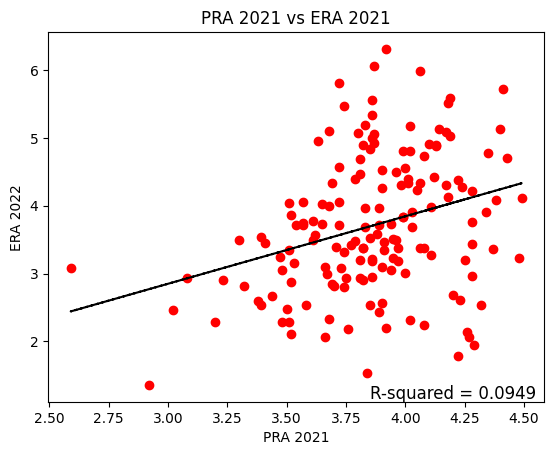

0.0949388844088809


In [31]:
x = final["PRA2021"].values.reshape(-1, 1)
y = final["ERA2022"].values.reshape(-1, 1)

model = LinearRegression().fit(x, y)
pred = model.predict(x)

plt.scatter(final["PRA2021"], final["ERA2022"], color = "red")
plt.plot(x, pred, linestyle = "--", color = 'black',  label='Regression Line')

plt.xlabel("PRA 2021")
plt.ylabel("ERA 2022")
plt.title("PRA 2021 vs ERA 2021")
plt.text(4.55, 1.1, "R-squared = 0.0949", fontsize = 12, color = 'black', va = 'bottom', ha = 'right')

#plt.savefig("PRA.png")
plt.show()

print((np.corrcoef(final["PRA2021"], final["ERA2022"])[0, 1]) ** 2)

final["Residuals"] = y - pred

In [18]:
RMSE = np.sqrt(np.mean(final['Residuals']**2))
print(f"The RMSE is {(RMSE)}")

The RMSE is 0.9638693674833313
